In [1]:
import sys
import pandas as pd
import numpy as np
from numpy import mean
import time
import imdb
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
plt.style.use('ggplot')
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
import re

#function that uses a regex to extract data we need from various cols in dataset
def extractData(str):
    return re.findall("'name': \'(.+?)\'", str)

In [3]:
#function to get past movie success
def calcPastSuccess(movie, ia):
    start_time = time.time()
    for i in range(8):
        actor = movie['cast'][i]
        filmList = ia.get_person_filmography(actor.getID())['data']['filmography'][0]
        filmography = filmList.get('actor')
        if filmography is None:
            filmography = filmList.get('actress')

        totalRating = 0
        totalBO = 0
        movieCount = 0
        accMovieCount = 0
        for film in filmography:
            if film['kind'] == 'movie':
                film = ia.get_movie(film.getID())
                rating = film.get("rating")
                boxOffice = film.get("box office")
                if boxOffice is not None :
                    gross = boxOffice.get('Cumulative Worldwide Gross')
                else:
                    gross = None

                accMovieCount += 1
                if rating is not None and gross is not None:
                    totalRating += float(rating)
                    gross = gross.split(' ')[0][1:].replace(',','')
                    totalBO += float(gross)
                    movieCount += 1
        if movieCount > 0:
            AvgIMDbScore = totalRating/movieCount
            AvgBO = totalBO/movieCount
        else:
            AvgIMDbScore = 0
            AvgBO = 0
        print("Statistics for", actor)
        print('Number of Movies used in formula: ',movieCount)
        print('Number of Movies Total: ', accMovieCount)
        print("Average IMDb Score: ", AvgIMDbScore)
        pastIMDbFormula = AvgIMDbScore - 10 * (1/3)**movieCount
        pastBoxOfficeFormula = 10* (AvgBO / 100000000) - 10 * (1/3)**movieCount

        print('IMDb Weighted Average Rating for: ', pastIMDbFormula)
        print('Box Office Weighted Average for: ', pastBoxOfficeFormula)
        print("--- %s minutes ---" % ((time.time() - start_time)/60))
        print()

In [4]:
#Load in the data
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
#Look at all of the columns
print(train.columns)

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')


In [5]:
#Drop columns we will not be using and inspect the head of df
train = train.drop(columns=[ 'homepage', 'poster_path', 'original_title', 'overview','tagline','Keywords'])
train.head(10)

,id,belongs_to_collection,budget,genres,imdb_id,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,title,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",tt2637294,en,6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Hot Tub Time Machine 2,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",tt0368933,en,8.248895,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Princess Diaries 2: Royal Engagement,"[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",tt2582802,en,64.299990,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Whiplash,"[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",tt1821480,hi,3.174936,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Kahaani,"[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",tt1380152,ko,1.148070,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,Marine Boy,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970
5,6,NaN,8000000,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",tt0093743,en,0.743274,NaN,NaN,8/6/87,83.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Pinocchio and the Emperor of the Night,"[{'cast_id': 6, 'character': 'Pinocchio (voice...","[{'credit_id': '52fe46f49251416c9106558b', 'de...",3261638
6,7,NaN,14000000,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",tt0431021,en,7.286477,"[{'name': 'Ghost House Pictures', 'id': 768}, ...","[{'iso_3166_1': 'US', 'name': 'United States o...",8/30/12,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Possession,"[{'cast_id': 23, 'character': 'Clyde', 'credit...","[{'credit_id': '52fe4981c3a368484e12ee29', 'de...",85446075
7,8,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",tt0391024,en,1.949044,NaN,NaN,1/15/04,84.0,"[{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso...",Released,Control Room,"[{'cast_id': 2, 'character': 'Himself', 'credi...","[{'credit_id': '52fe47a69251416c750a0daf', 'de...",2586511
8,9,"[{'id': 256377, 'name': 'The Muppet Collection...",0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",tt0117110,en,6.902423,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/16/96,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Muppet Treasure Island,"[{'cast_id': 1, 'character': 'Long John Silver...","[{'credit_id': '52fe43c89251416c7501deb3', 'de...",34327391
9,10,NaN,6000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",tt0310281,en,4.672036,"[{'name': 'Castle Rock Entertainment', 'id': 97}]","[{'iso_3166_1': 'US', 'name': 'United States o...",4/16/03,91.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Mighty Wind,"[{'cast_id': 24, 'character': 'Jonathan Steinb...","[{'credit_id': '52fe45609251416c750545b3', 'de...",18750246


In [6]:
print(train.shape)

(3000, 17)


In [7]:
print(train.describe())

                id        budget   popularity      runtime       revenue
count  3000.000000  3.000000e+03  3000.000000  2998.000000  3.000000e+03
mean   1500.500000  2.253133e+07     8.463274   107.856571  6.672585e+07
std     866.169729  3.702609e+07    12.104000    22.086434  1.375323e+08
min       1.000000  0.000000e+00     0.000001     0.000000  1.000000e+00
25%     750.750000  0.000000e+00     4.018053    94.000000  2.379808e+06
50%    1500.500000  8.000000e+06     7.374861   104.000000  1.680707e+07
75%    2250.250000  2.900000e+07    10.890983   118.000000  6.891920e+07
max    3000.000000  3.800000e+08   294.337037   338.000000  1.519558e+09


In [8]:
#replace all NA values to empty strings so we can extract data cleanly
train.genres = train.genres.fillna("")
train.production_companies = train.production_companies.fillna("")
train.production_countries = train.production_countries.fillna("")
train.spoken_languages = train.spoken_languages.fillna("")

In [9]:
#use helper function to extract data from necessary features
train['genres_reform'] = train['genres'].apply(lambda x: extractData(x))
train['production_companies_reform'] = train['production_companies'].apply(lambda x: extractData(x))
train['production_countries_reform'] = train['production_countries'].apply(lambda x: extractData(x))
train['spoken_languages_reform'] = train['spoken_languages'].apply(lambda x: extractData(x))

In [10]:
train.head()

,id,belongs_to_collection,budget,genres,imdb_id,original_language,popularity,production_companies,production_countries,release_date,...,spoken_languages,status,title,cast,crew,revenue,genres_reform,production_companies_reform,production_countries_reform,spoken_languages_reform
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",tt2637294,en,6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Hot Tub Time Machine 2,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,[Comedy],"[Paramount Pictures, United Artists, Metro-Gol...",[United States of America],[English]
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",tt0368933,en,8.248895,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Princess Diaries 2: Royal Engagement,"[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,"[Comedy, Drama, Family, Romance]",[Walt Disney Pictures],[United States of America],[English]
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",tt2582802,en,64.299990,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Whiplash,"[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,[Drama],"[Bold Films, Blumhouse Productions, Right of W...",[United States of America],[English]
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",tt1821480,hi,3.174936,,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Kahaani,"[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,"[Thriller, Drama]",[],[India],"[English, हिन्दी]"
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",tt1380152,ko,1.148070,,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,...,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,Marine Boy,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,"[Action, Thriller]",[],[South Korea],[한국어/조선말]


In [11]:
# you can easily index through it now, like so:
print(train['genres_reform'][1])
for genre in train['genres_reform'][1]:
    print(genre)

['Comedy', 'Drama', 'Family', 'Romance']
Comedy
Drama
Family
Romance


In [12]:
#making a copy so i can play with stuff and show you how i've done some things without changing the real dataset
df = train.copy(deep=True)

In [13]:
# Will likely make this another separate file as a helper function, can be used for several of the features
def unpackCol(list, df):
    for i in range(len(df)):
        for name in list[i]:
            if name not in df.columns:
                df[name] = 0
            df[name][i] = 1
    return df

In [14]:
# stripping the 'tt' from the idmb id, only used in url and easier to get movies without it
df['imdb_id'] = df['imdb_id'].str[2:]
df['imdb_id']

0       2637294
1       0368933
2       2582802
3       1821480
4       1380152
         ...   
2995    0109403
2996    2364975
2997    0116908
2998    0343135
2999    1600195
Name: imdb_id, Length: 3000, dtype: object

Belongs to Collection

In [15]:
# here is a quick line to sort out the collection stuff
df.belongs_to_collection = df.belongs_to_collection.apply(lambda x: 1 if type(x) == str else 0)

In [16]:
print(df.belongs_to_collection)
print()
print('Total movies in collections:', sum(df.belongs_to_collection))
print('Total movies not in collections:', (df.belongs_to_collection == 0).sum(axis=0))

0       1
1       1
2       0
3       0
4       0
       ..
2995    0
2996    0
2997    0
2998    0
2999    0
Name: belongs_to_collection, Length: 3000, dtype: int64

Total movies in collections: 604
Total movies not in collections: 2396


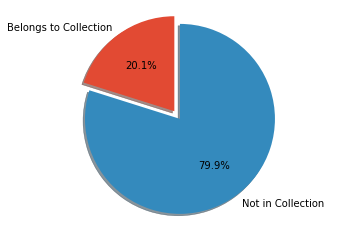

In [17]:
# plotting belongs to collection data
labels = 'Belongs to Collection', 'Not in Collection'
btc_1 = [sum(df.belongs_to_collection), (df.belongs_to_collection == 0).sum(axis=0)]
explode = (0.1, 0)

# plot
fig, ax = plt.subplots()
ax.pie(btc_1, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal') # ensures chart is a circle

plt.show()

From a total of 3000 data points, 604 or 20.1% were a part of a collection of films, while the other 2396 or 79.9% were not. Belonging to a collection has the potential to be an important feature when predicting revenue as customers may be more likely to pay for a movie-going experience when it is the next iteration of a series into which they have already invested time and money. The origin of serial media is largely accredited to The Pickwick Papers, written by Charles Dickens in 1836, and has since boomed all the way into the 21st century. Given the current and historic popularity of the format, it is hypothesized that belonging to a collection will indicate a positive correlation with revenue.

In [18]:
df.isna().sum()

id                              0
belongs_to_collection           0
budget                          0
genres                          0
imdb_id                         0
original_language               0
popularity                      0
production_companies            0
production_countries            0
release_date                    0
runtime                         2
spoken_languages                0
status                          0
title                           0
cast                           13
crew                           16
revenue                         0
genres_reform                   0
production_companies_reform     0
production_countries_reform     0
spoken_languages_reform         0
dtype: int64

Not in Collection        2396
Belongs in Collection     604
Name: has_collection, dtype: int64


Text(0.5, 0, 'Collection Status')

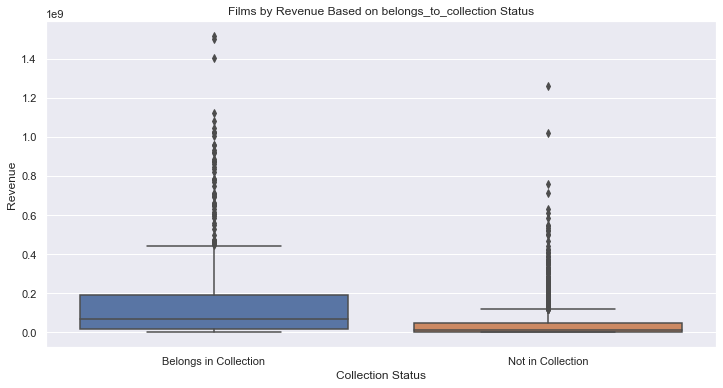

In [19]:
# bivariate analysis of revenue with belongs_to_collection
df['has_collection'] = df['belongs_to_collection'].apply(lambda x: 'Belongs in Collection' if x == 1 else 'Not in Collection')
print(df['has_collection'].value_counts())

sns.set(rc={'figure.figsize':(12, 6)})
sns.boxplot(x='has_collection', y='revenue', data=df)
plt.title('Films by Revenue Based on belongs_to_collection Status')
plt.ylabel("Revenue")
plt.xlabel("Collection Status")

The graph above supports the hypothesis that belonging to a collection enhances a film's revenue in a positive correlation. More work could be done to quantify the precise benefit associated with a film's status as 'Belongs in Collection.'

Genres

In [20]:
# example of using it to unpack the genres 
df = unpackCol(df['genres_reform'], df)

In [21]:
# here's what it did
print(df.columns)
print()
print(df['Drama'])
print()
# this total number lines up with what other people had too for amount of dramas, so assuming it is correct
print('Total number of Dramas: ', sum(df['Drama']))

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'imdb_id',
       'original_language', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'title', 'cast', 'crew', 'revenue', 'genres_reform',
       'production_companies_reform', 'production_countries_reform',
       'spoken_languages_reform', 'has_collection', 'Comedy', 'Drama',
       'Family', 'Romance', 'Thriller', 'Action', 'Animation', 'Adventure',
       'Horror', 'Documentary', 'Music', 'Crime', 'Science Fiction', 'Mystery',
       'Foreign', 'Fantasy', 'War', 'Western', 'History', 'TV Movie'],
      dtype='object')

0       0
1       1
2       1
3       1
4       0
       ..
2995    0
2996    1
2997    0
2998    0
2999    0
Name: Drama, Length: 3000, dtype: int64

Total number of Dramas:  1531


In [22]:
# lambda for featurizing the genre data
df_test = df['genres_reform'].apply(frozenset).to_frame(name='genre')
for genre in frozenset.union(*df_test.genre):
    df_test[genre] = df_test.apply(lambda _: int(genre in _.genre), axis=1)
df_test.head()

,genre,History,Family,Science Fiction,Thriller,Adventure,Music,Foreign,TV Movie,Drama,...,Animation,Mystery,Comedy,Documentary,Fantasy,Crime,Action,Horror,Western,War
0,(Comedy),0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,"(Family, Drama, Comedy, Romance)",0,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2,(Drama),0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,"(Drama, Thriller)",0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,"(Thriller, Action)",0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Text(0.5, 0, 'Genre')

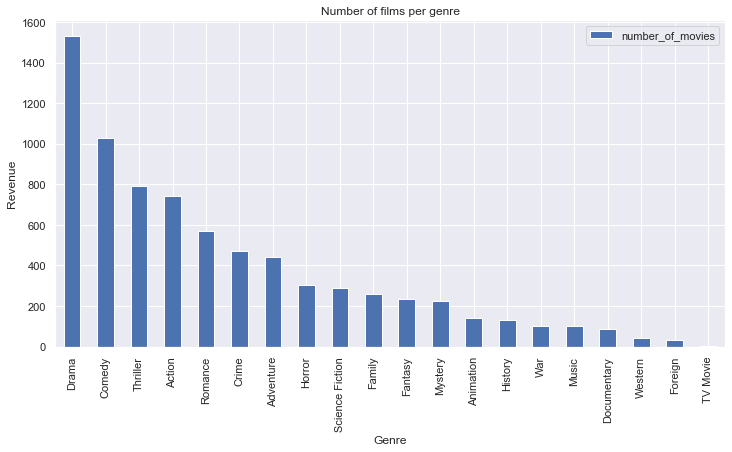

In [23]:
# plotting genres in order of number of instances in the train.csv dataset
genres_dict = dict()

for genre in df["genres_reform"]:
    for elem in genre:
        if elem not in genres_dict:
            genres_dict[elem] = 1
        else:
            genres_dict[elem] += 1


sns.set(rc={'figure.figsize':(12,6)})
genres_df = pd.DataFrame.from_dict(genres_dict, orient='index')
genres_df.columns = ["number_of_movies"]
genres_df = genres_df.sort_values(by="number_of_movies", ascending=False)
genres_df.plot.bar()
plt.title("Number of films per genre")
plt.ylabel("Revenue")
plt.xlabel("Genre")

Genres of movies follow certain trends in popularity; such as the latest boom of superhero movies originating in the 1990s with 20th Century Fox's X-Men series. Although superhero films have been around since at least 1978 with Richard Donner's Superman, the recent trend has helped define the film industry over the past two decades. For the purposes of this report, Action/Adventure films (and Fantasy) encompass superhero films, but also many other types of popular films subgenres.

Action and Adventure do relatively well in terms of number of films, so it could be hypothesized that more common genres are more popular, meaning that Drama, Comedy, and Thriller movies should see the highest respective revenues. Regardless, the importance of genre for determining the revenue of a film (and likewise predicting future success) will be highly useful given the sometimes nebulous patterns of viewership. 

In [24]:
# list of film genres by order of number of films in set
print(df['Drama'].sum())
print(df['Comedy'].sum())
print(df['Thriller'].sum())
print(df['Action'].sum())
print(df['Romance'].sum())
print(df['Crime'].sum())
print(df['Adventure'].sum())
print(df['Horror'].sum())
print(df['Science Fiction'].sum())
print(df['Family'].sum())
print(df['Fantasy'].sum())
print(df['Mystery'].sum())
print(df['Animation'].sum())
print(df['History'].sum())
print(df['War'].sum())
print(df['Music'].sum())
print(df['Documentary'].sum())
print(df['Western'].sum())
print(df['Foreign'].sum())
print(df['TV Movie'].sum())

1531
1028
789
741
571
469
439
301
290
260
232
225
141
132
100
100
87
43
31
1


In the case of genres, we see a near logarithmic function from Drama (1531 films) to TV Movies (1). It is assumed that this dataset is representative of broader filmography trends for the purposes of constructing hypotheses about the data. The more popular genres should typically see a likewise correlation in revenue given the increased popularity. However, it is worth considering the unique attraction of 'rare genre' films. Musicals like La La Land grossed S446.1 million for its Box Office total and did so with only a $30 million budget. Therefore, the possibility for outliers or even inverse hypotheses are worth considering.

In [25]:
# creating a callable index for genres
genres_df.index.values
for g in genres_df.index.values:
    df['genre_' + g] = df['genres_reform'].apply(lambda x: 1 if g in x else 0)

In [26]:
# bivariate analysis of revenue with genre
# median revenue per genre type
for i, g in enumerate(genres_df.index.values):
    genres_df.loc[g, "median_rev"] = df[df['genre_' + g]==1].revenue.median()
    
genres_df.sort_values(by=["number_of_movies", "median_rev"], ascending=False).head(10)

# mean revenue for genre type
for i, g in enumerate(genres_df.index.values):
    genres_df.loc[g, "mean_rev"] = df[df['genre_' + g]==1].revenue.mean()

genres_df.sort_values(by=["number_of_movies", "mean_rev"], ascending=False).head(10)

,number_of_movies,median_rev,mean_rev
Drama,1531,11293663.0,4.540607e+07
Comedy,1028,18809184.0,6.087574e+07
Thriller,789,21890845.0,6.833664e+07
Action,741,36000000.0,1.110434e+08
Romance,571,14016568.0,5.270501e+07
Crime,469,24048000.0,5.949128e+07
Adventure,439,59700000.0,1.758095e+08
Horror,301,17037887.0,5.270907e+07
Science Fiction,290,35109301.5,1.223672e+08
Family,260,57470029.5,1.388978e+08


Text(0.5, 0, 'Genre')

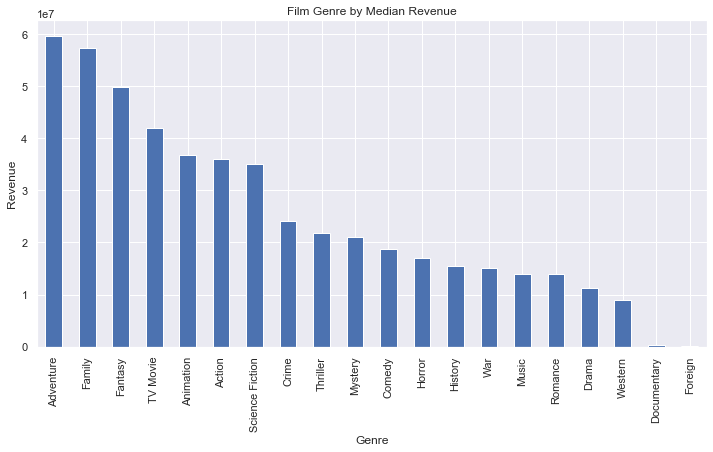

In [27]:
# genres by median revenue
genres_df.sort_values(by=["median_rev"], ascending=False).median_rev.plot.bar()
plt.title("Film Genre by Median Revenue")
plt.ylabel("Revenue")
plt.xlabel("Genre")

Text(0.5, 0, 'Genre')

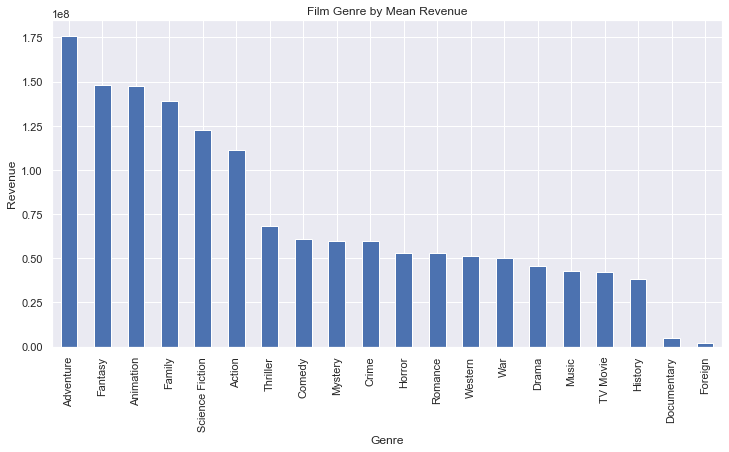

In [28]:
# genres by mean revenue
genres_df.sort_values(by=["mean_rev"], ascending=False).mean_rev.plot.bar()
plt.title("Film Genre by Mean Revenue")
plt.ylabel("Revenue")
plt.xlabel("Genre")

In both 'Film Genre by Median Revenue' and 'Film Genre by Mean Revenue' Adventure films have the highest revenue values, with fairly consistent ordering down save a few notable changes. For example, using 'median_rev' the TV Movie genre scores fourth highest revenue, while using 'mean_rev' lowers the genre to fourth lowest revenue. History loses five places from 'median_rev' to 'mean_rev' and Comedy goes up three.

Although some common film genres (those with higher numbers of films in the training data) do well with regards to revenue, the overall hypothesis that commonality of a film would correlate positively to revenue is disproven with the relatively lower revenues for Dramas, Comedies, and Thrillers (the top three most numerous film genres). This could be a result of saturated genre demand, or it could be unrelated. What is certain is that Adventure, Family, Fantasy, and Animation score well with regards to median and mean revenue.

Popularity

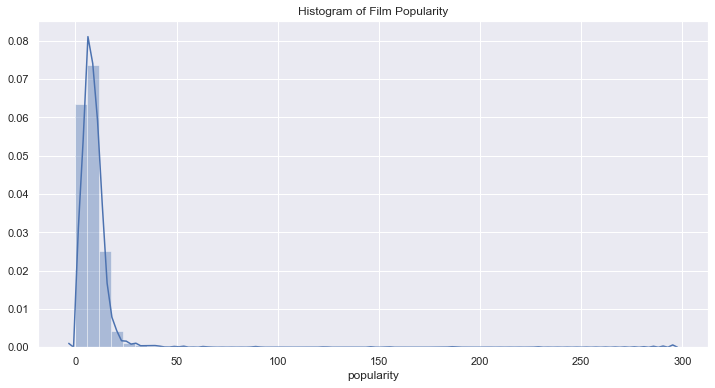

In [29]:
# plotting popularity
sns.distplot(df['popularity'], kde=True)
sns.set(rc={'figure.figsize':(12, 6)})
plt.title('Histogram of Film Popularity')
plt.show();

In [30]:
print(df['popularity'].describe())

count    3000.000000
mean        8.463274
std        12.104000
min         0.000001
25%         4.018053
50%         7.374861
75%        10.890983
max       294.337037
Name: popularity, dtype: float64


Popularity is likely to be a significant feature in prediting revenue outcome given the importance of popularity for movie viewership (this is of course contingent upon popularity refering to the 'hype' surrounding a film and not the post-release ratings - if the later than popularity should more directly map to revenue in theory). Because of the more popularity is a good thing for marketing, and thus increased ticket sales, it is hypothesized that popularity and revenue will have a positive correlation. 

Above it is seen that of the 3000 films in the dataset the average popularity was an 8.46 with a minimum of 0.00 and a max of 294.34. The histogram reveals that the bulk of the films fall between a popularity score of 0 and 25, with sparse highly popular outliers. Dealing with these outliers will be addressed later.

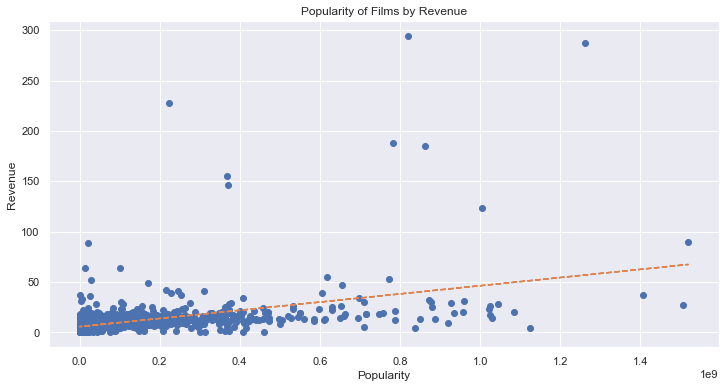

In [31]:
# bivariate: plotting popularity and revenue
cx = df['revenue']
pop = df['popularity']
plt.plot(cx, pop, 'o')
plt.ylabel("Revenue")
plt.xlabel("Popularity")
plt.title("Popularity of Films by Revenue")

z = np.polyfit(cx, pop, 1)
p = np.poly1d(z)
plt.plot(cx, p(cx), "--");

In comparing popularity against revenue, there is an overall positive correlation. This is to be expected given the influence of popularity on a film's monetary success via more developed viewership. Further investigation should be conducted by playing around with the outlier values; notably, certain highly popular films do not see concurrently higher revenue, which leads to the conclusion that popularity is not a perfect indicator of a movie's revenue.

However, because of the confusion regarding outliers and the scale around which this value is produced, the feature is lacking in clarity. More detrimentally, the popularity can only be judged after the film has been released, which means it is not useful to a film studio as a metric by which to predict box office totals. Instead, popularity could be used as another label (akin to the idea of predicting for a movie's "rating" as opposed to its "revenue"). Regardless, for the purposes of this project the popularity feature will not be included in the model.

Production Companies

In [32]:
# new feature for a count of the number of production studios
df['num_studios'] = df.production_companies_reform.apply(lambda x: len(x))
print(df['num_studios'])

0       3
1       1
2       3
3       0
4       0
       ..
2995    2
2996    2
2997    3
2998    2
2999    6
Name: num_studios, Length: 3000, dtype: int64


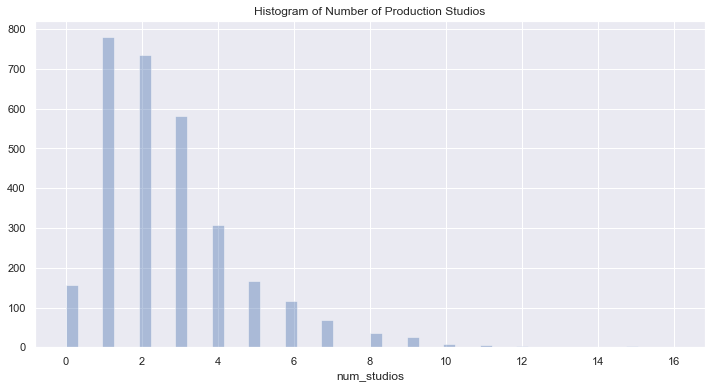

In [33]:
# plotting films by number of production studios
sns.distplot(df['num_studios'], kde=False)
sns.set(rc={'figure.figsize':(15,6)})
plt.title('Histogram of Number of Production Studios')
plt.show();

Most movies have between 1 and 4 production studios, with fewer films having higher numbers and some even with 0 studio partners (independent films). However, given only the sheer number of production studios it is difficult to produce a reasonable hypothesis regarding the box office success of the film. Instead, determining the larger, more established, or otherwise previously successful production studios and applying those findings toward whether or not the dataset films in question have said studios would be a more useful way to analyze the impact of production companies.

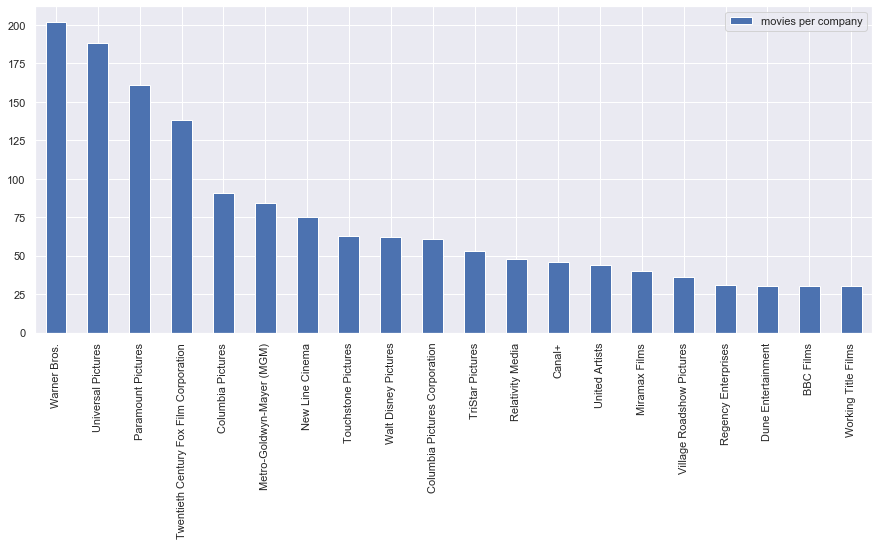

In [34]:
# production companies
companiesDict = {}
for element in train["production_companies_reform"].values:
    for company in element:
        if company not in companiesDict:
            companiesDict[company] = 1
        else:
            companiesDict[company] += 1

companies_df = pd.DataFrame.from_dict(companiesDict, orient='index', columns=["movies per company"])
companies_df.sort_values(by="movies per company", ascending=False).head(20).plot.bar()

companies_df.columns = ["number_of_studios"]

Using the number of movies per production company may be useful for determining what the biggest studios are, and correlating how the size of a production company influences the success of its films. There are two possibilities; either 1. a larger studio has the funding and means to draw in big-name cast and crew, with the necessary experience to turn that into a successful film project or 2. the studio is too franchised to create successful novel ideas and merely continually pumps out mediocre performing films. While some of both is likely possible, machine learning will help to weigh the relative influence of studio size on the movie's predicted revenue. Marking whether or not one of these major studios is involved in a film will be a useful feature for determining this connection.

In [35]:
# creating a callable index for production studios
companies_df.index.values
for g in companies_df.index.values:
    df['name_' + g] = df['production_companies_reform'].apply(lambda x: 1 if g in x else 0)

In [41]:
# bivariate analysis of revenue with production studios
# median revenue per production studio
for i, g in enumerate(companies_df.index.values):
    companies_df.loc[g, "median_rev"] = df[df['name_' + g]==1].revenue.median()
    
companies_df.sort_values(by=["number_of_studios", "median_rev"], ascending=False).head(10)

# mean revenue per production studio
for i, g in enumerate(companies_df.index.values):
    companies_df.loc[g, "mean_rev"] = df[df['name_' + g]==1].revenue.mean()

companies_df.sort_values(by=["number_of_studios", "mean_rev"], ascending=False).head(10)

# total revenue per production studio
for i, g in enumerate(companies_df.index.values):
    companies_df.loc[g, "sum_rev"] = df[df['name_' + g]==1].revenue.sum()

companies_df.sort_values(by=["number_of_studios", "sum_rev"], ascending=False).head(10)

,number_of_studios,median_rev,mean_rev,sum_rev
Warner Bros.,202,55653705.5,1.203347e+08,2.430760e+10
Universal Pictures,188,59540581.5,1.096708e+08,2.061812e+10
Paramount Pictures,161,52034889.0,1.247831e+08,2.009007e+10
Twentieth Century Fox Film Corporation,138,50589532.0,1.139619e+08,1.572674e+10
Columbia Pictures,91,77737889.0,1.202844e+08,1.094588e+10
Metro-Goldwyn-Mayer (MGM),84,13220811.0,6.872146e+07,5.772602e+09
New Line Cinema,75,60740827.0,1.451592e+08,1.088694e+10
Touchstone Pictures,63,34808403.0,7.654655e+07,4.822432e+09
Walt Disney Pictures,62,160440216.0,3.037771e+08,1.883418e+10
Columbia Pictures Corporation,61,58853106.0,7.591135e+07,4.630592e+09


Text(0.5, 0, 'Production Studio')

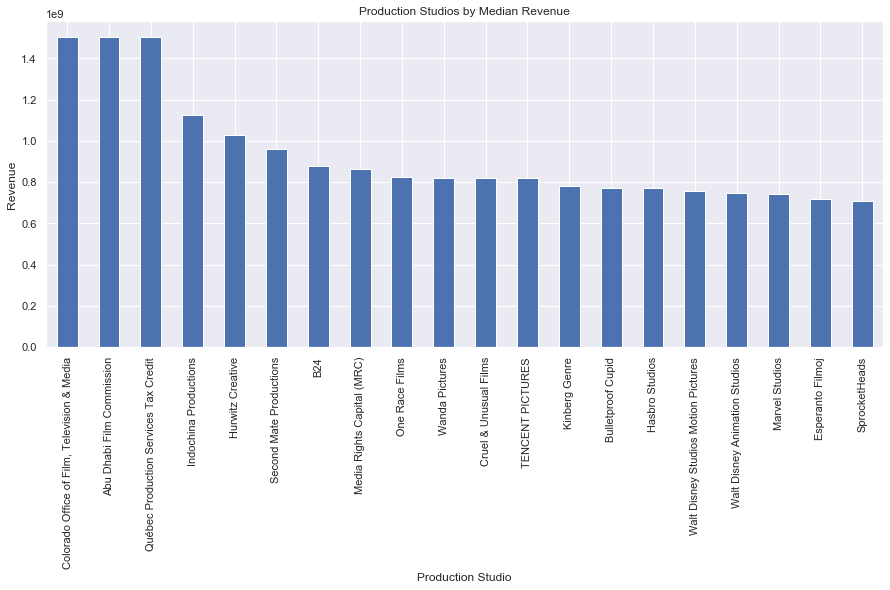

In [38]:
# production studios by median revenue
companies_df.sort_values(by=["median_rev"], ascending=False).median_rev.head(20).plot.bar()
plt.title("Production Studios by Median Revenue")
plt.ylabel("Revenue")
plt.xlabel("Production Studio")

Text(0.5, 0, 'Production Studio')

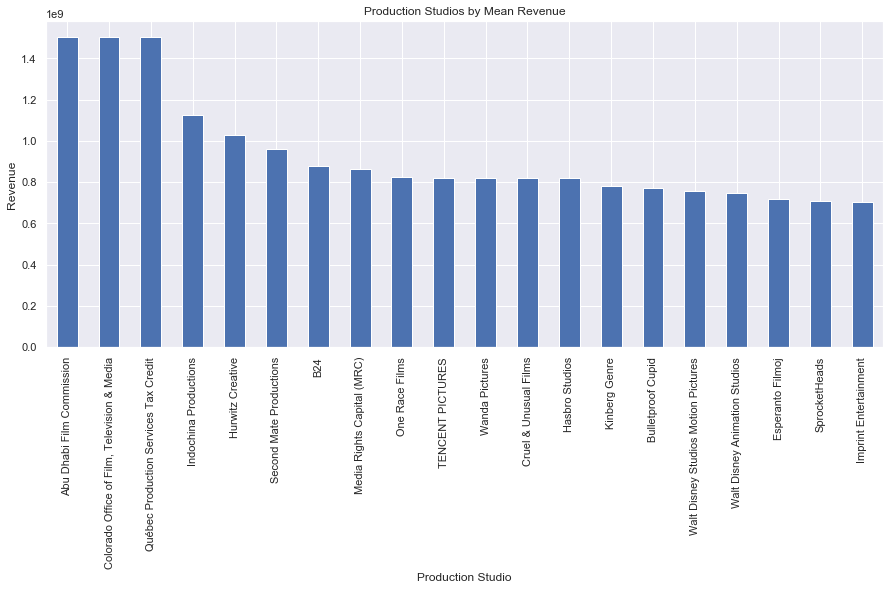

In [39]:
# production studios by mean revenue
companies_df.sort_values(by=["mean_rev"], ascending=False).mean_rev.head(20).plot.bar()
plt.title("Production Studios by Mean Revenue")
plt.ylabel("Revenue")
plt.xlabel("Production Studio")

Both mean and median revenue compared against the production studio provide relatively uninformative results. Namely, the Colorado Office of Film, Television & Media appears as a minor production studio for 'Furious 7' of the Fast & Furious Film Franchise. This is the only time it appears on the list, greatly skewing its influence on a film's revenue. Similarly, the Abu Dhabi Film Commision is involved in Furious 7 and seven other films including the highly profitable 'Ghost Rider: Spirit of Vengeance.' These outliers are unduly weighted with greater importance using this system, but other options exist.

Firstly, the total revenue of each production company can be analyzed to see the studio with the overall highest box office totals (although this is expected to mirror the largest studios with the greatest number of films). Secondly, the mean and median revenue values can be applied to only the primary production company working on a film.

Text(0.5, 0, 'Production Studio')

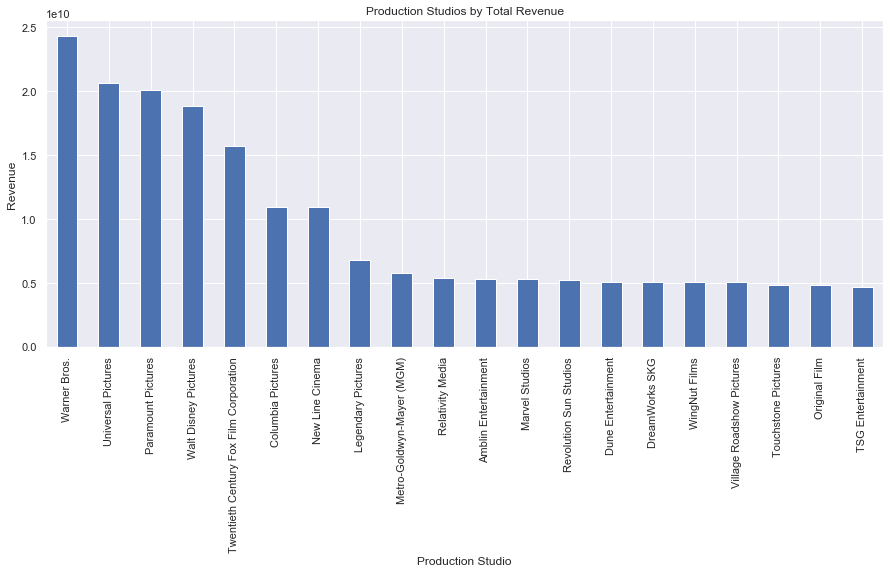

In [43]:
# production studios by total revenue
companies_df.sort_values(by=["sum_rev"], ascending=False).sum_rev.head(20).plot.bar()
plt.title("Production Studios by Total Revenue")
plt.ylabel("Revenue")
plt.xlabel("Production Studio")

As expected, the production studios largely mirror the studios with the largest number of films produced. One notable exception is Walt Disney Pictures which rises from ninth place in terms of films produced to fourth place for total revenue. While other studios change position some, the focus on primary studios should also be tried.

Release Date

In [88]:
# release date data manipulation
# naming a date-specific dataframe for housekeeping
df_date = df['release_date']

# converting to datetime format, with .dt used for accessing quantities
df_date = pd.to_datetime(df_date)
df_date.dt
print(df_date)

0      2015-02-20
1      2004-08-06
2      2014-10-10
3      2012-03-09
4      2009-02-05
          ...    
2995   1994-04-22
2996   2013-03-28
2997   1996-10-11
2998   2004-01-16
2999   2011-09-22
Name: release_date, Length: 3000, dtype: datetime64[ns]


In [89]:
# possible output options
print(df_date.dt.year) # absolutely necessary
print(df_date.dt.dayofweek) # friday night hits!
print(df_date.dt.dayofyear) # it's a christmas miracle
print(df_date.dt.weekofyear) # idk might be interesting

0       2015
1       2004
2       2014
3       2012
4       2009
        ... 
2995    1994
2996    2013
2997    1996
2998    2004
2999    2011
Name: release_date, Length: 3000, dtype: int64
0       4
1       4
2       4
3       4
4       3
       ..
2995    4
2996    3
2997    4
2998    4
2999    3
Name: release_date, Length: 3000, dtype: int64
0        51
1       219
2       283
3        69
4        36
       ... 
2995    112
2996     87
2997    285
2998     16
2999    265
Name: release_date, Length: 3000, dtype: int64
0        8
1       32
2       41
3       10
4        6
        ..
2995    16
2996    13
2997    41
2998     3
2999    38
Name: release_date, Length: 3000, dtype: int64


In [90]:
print(df.release_date.describe())
print()
print(df_date.dt.year.describe())

count        3000
unique       2398
top       9/10/15
freq            5
Name: release_date, dtype: object

count    3000.000000
mean     2004.779667
std        15.664767
min      1970.000000
25%      1995.000000
50%      2006.000000
75%      2012.000000
max      2069.000000
Name: release_date, dtype: float64


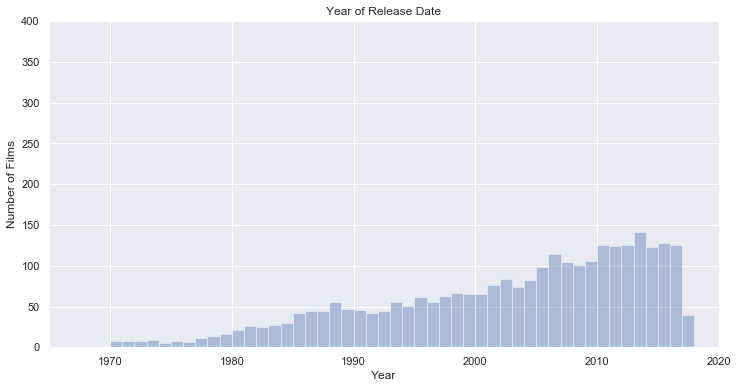

In [91]:
# plotting the year of the films release
fig, dx = plt.subplots()
sns.distplot(df_date.dt.year, bins=99, kde=False)
sns.set(rc={'figure.figsize':(15, 6)})

dx.set(xlim=(1965, 2020),ylim=(0,400))
dx.set_xlabel("Year")
dx.set_ylabel("Number of Films")
dx.set_title("Year of Release Date")

# dx.set_xticklabels(dx.get_xticklabels(), rotation=-45)

plt.show();

The plot for year of release for the dataset shows a general increase in number of films as time progresses, which makes sense for a growing/maturing industry. While mostly linear, there are several peaks throughout. Finding a relationship between the years with above average number films and revenue could be an interesting direction for investigation.

In [92]:
# bivariate year of release


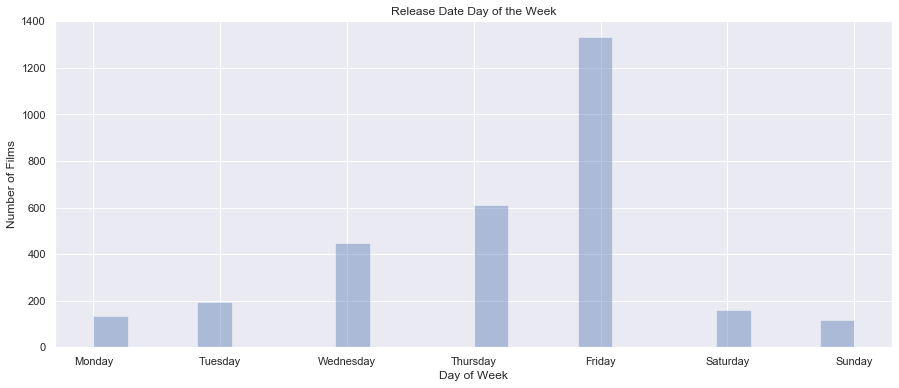

In [93]:
# plotting the films release day of the week
fig, ex = plt.subplots()
sns.distplot(df_date.dt.dayofweek, kde=False)
sns.set(rc={'figure.figsize':(15,6)})

ex.set_xlabel("Day of Week")
ex.set_ylabel("Number of Films")
ex.set_title("Release Date Day of the Week")

labels = [item.get_text() for item in ex.get_xticklabels()]
labels[1] = 'Monday'
labels[2] = 'Tuesday'
labels[3] = 'Wednesday'
labels[4] = 'Thursday'
labels[5] = 'Friday'
labels[6] = 'Saturday'
labels[7] = 'Sunday'

ex.set_xticklabels(labels)

plt.show();

The dayofweek data shows a clear outlier in Friday release days, which is somewhat obviously tied to the end of the common Monday to Friday five day workweek. Individuals are more likely to attend a several hour long event after work if they have fewer responsibilities the following day. A movie's release is expected to follow market patterns that best benefit the film, so it is hypothesized that Friday release dates will have a positive impact on sales (and by association box office totals). Unexpectedly, Saturday release dates are lower even than Tuesday, Wednesday, and Thursday - it might be logical to assume many movie-goers would attend a film opening on Saturday.

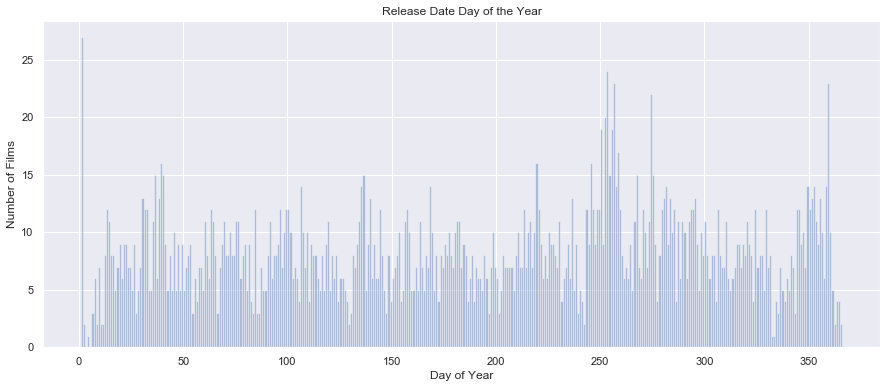

In [94]:
# plotting the films release day of the year
fig, fx = plt.subplots()
sns.distplot(df_date.dt.dayofyear, bins=365, kde=False)
sns.set(rc={'figure.figsize':(15,6)})

fx.set_xlabel("Day of Year")
fx.set_ylabel("Number of Films")
fx.set_title("Release Date Day of the Year")

plt.show();

The dayofyear data is a fairly noisy set of data, however as expected, there are certain days with notably higher numbers of films produced. For example, the Christmas Eve and New Years Day release dates are well-known as popular choices for when to release a movie. Whether this is an advent largely born out of tradition or out of true benefit to revenue will be parsed in later data exploration. 

There is also a clumping of films curiously released in September. Further research reveals that August and September are among the months listed as 'dump months' during which a large number of films that did bad in testing, star a less prominent cast, or otherwise cannot be easily marketted. This aligns with the return of children to the public school system after summer as well as other indicators of a slump period for the film industry. So high number of releases could be positive in some cases and negative in others. In fact, periods with low release may be due to a major title opening (with the studios wanting less box office competition).

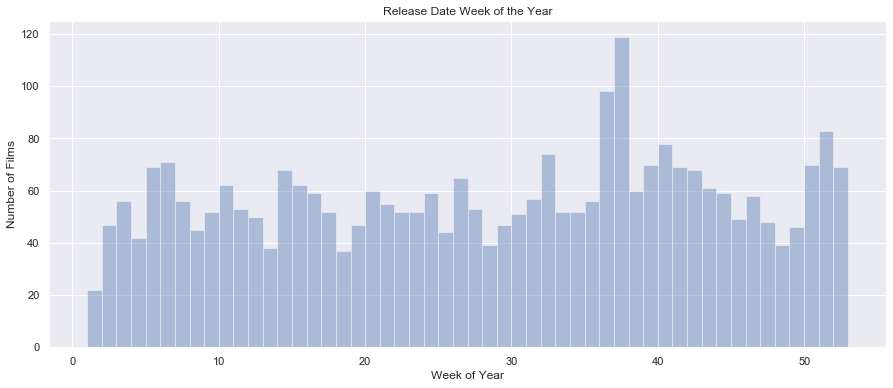

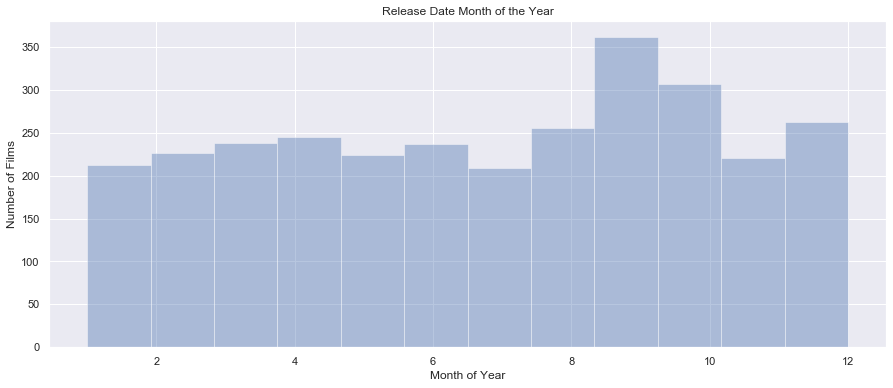

In [97]:
# plotting the films release week of the year
fig, fx = plt.subplots()
sns.distplot(df_date.dt.weekofyear, bins=52, kde=False)
sns.set(rc={'figure.figsize':(15,6)})

fx.set_xlabel("Week of Year")
fx.set_ylabel("Number of Films")
fx.set_title("Release Date Week of the Year")

plt.show();

print()

# plotting the films release month of the year
fig, fx = plt.subplots()
sns.distplot(df_date.dt.month, bins=12, kde=False)
sns.set(rc={'figure.figsize':(15,6)})

fx.set_xlabel("Month of Year")
fx.set_ylabel("Number of Films")
fx.set_title("Release Date Month of the Year")

plt.show();

Similarly to the dayofyear data, the weekofyear data shows the highest number of films released at the end of August and beginning of September. As the 'dump months' this is unlikely to be indicative of a positive correlation with revenue. The second largest spike in December may have better box office totals due to the popularity of going to the movies over the holidays. Late Fall into Winter are typically denoted as the beginning of Oscar Season, which could mean higher grossing films released regardless of the overall number of film. As such, it can be theorized that the number of films released in a given week of the year is not as important as the characteristics of that week with respect to the film industry's cyclical patterns.

Spoken Languages

In [43]:
# new feature for a count of the number of spoken languages
df['num_languages'] = df.spoken_languages_reform.apply(lambda x: len(x))
print(df['num_languages'])

0       1
1       1
2       1
3       2
4       1
       ..
2995    1
2996    1
2997    1
2998    1
2999    1
Name: num_languages, Length: 3000, dtype: int64


In [44]:
print(df.num_languages.describe())

count    3000.000000
mean        1.443000
std         0.880725
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: num_languages, dtype: float64


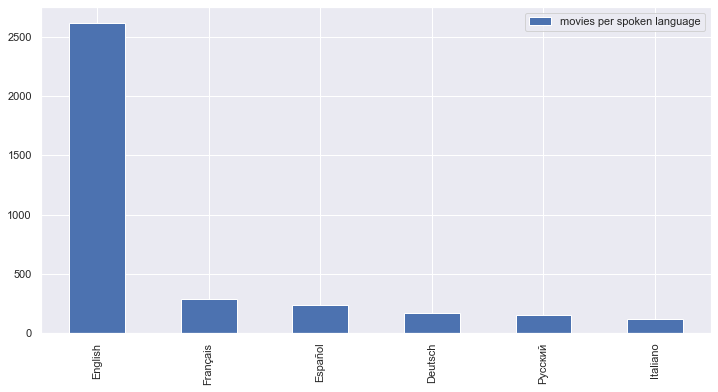

In [73]:
# univariate analysis of spoken languages
languagesDict = {}
for element in train["spoken_languages_reform"].values:
    for name in element:
        if name not in languagesDict:
            languagesDict[name] = 1
        else:
            languagesDict[name] += 1

languages_df = pd.DataFrame.from_dict(languagesDict, orient='index', columns=["movies per spoken language"])
languages_df.sort_values(by="movies per spoken language", ascending=False).head(6).plot.bar()

languages_df.columns = ["number_of_languages"]

Due to the significantly higher value for films with English as the spoken language, this value can likely be broken down to a simple, "Is English a spoken language or not?" This will provide interesting insight into the importance of English as the spoken language as a factor toward the movie's success. Because of the higher market for movies in English speaking countries (save perhaps India - although it is unclear if an appropriately proportioned number of Bollywood films are included in the training data). A sound hypothesis would be that English may not denote a successful movie, but an absence of English may harm the film's chance for being as successful.

In [80]:
# # working with spoken languages
# df["en"] = df.spoken_languages_reform.apply(lambda x: 1 if x == "English" else 0)
# print(df.spoken_english)

In [81]:
# #WIP
# # spoken languages (english vs non-english)
# labels = 'Spoken Language English', 'Other Spoken Language'
# df["spoken_languages_reform"] = df.spoken_languages_reform.apply(lambda x: 1 if x == "English" else 0)
# lang = [sum(df.spoken_english), (df.spoken_english == 0).sum(axis=0)]
# explode = (0.1, 0)

# # plot
# fig, ex = plt.subplots()
# ex.pie(lang, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
# ex.axis('equal')
# plt.show()

In [82]:
# # creating a callable index for spoken languages
# languages_df.index.values
# for g in languages_df.index.values:
#     df['lang_' + g] = df['spoken_languages_reform'].apply(lambda x: 1 if g in x else 0)

# # median revenue per production studio
# for i, g in enumerate(languages_df.index.values):
#     languages_df.loc[g, "median_rev"] = df[df['lang_' + g]==1].revenue.median()
    
# languages_df.sort_values(by=["number_of_languages", "median_rev"], ascending=False).head(10)

# # mean revenue per production studio
# for i, g in enumerate(languages_df.index.values):
#     languages_df.loc[g, "mean_rev"] = df[df['lang_' + g]==1].revenue.mean()

# languages_df.sort_values(by=["number_of_languages", "mean_rev"], ascending=False).head(10)

# # total revenue per production studio
# for i, g in enumerate(languages_df.index.values):
#     languages_df.loc[g, "sum_rev"] = df[df['lang_' + g]==1].revenue.sum()

# languages_df.sort_values(by=["number_of_languages", "sum_rev"], ascending=False).head(10)

In [ ]:
# bivariate plotting spoken languages (english) and revenue


Crew

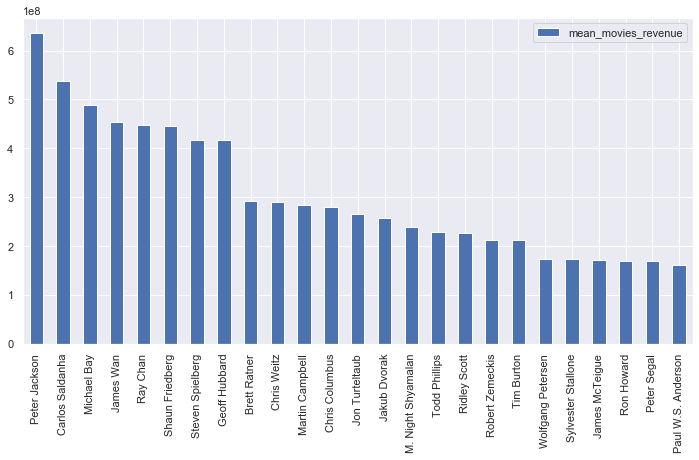

In [84]:
# bivariate directors
train.crew = train.crew.fillna("")
train['directors'] = train['crew'].apply(lambda x: re.findall("Director', 'name': '(.+?)'", x))

directorsDict = {}
for element in train[["revenue", "directors"]].values:

    for director in element[1]:
        if director not in directorsDict:
            directorsDict[director] = [element[0], 1]
        else:
            directorsDict[director][0] += element[0]
            directorsDict[director][1] += 1

directorsDict = {k: v for k, v in directorsDict.items() if v[1] >= 5}

for director in directorsDict:
    directorsDict[director][0] = directorsDict[director][0]/directorsDict[director][1]
    directorsDict[director] = directorsDict[director][0]

    
directors_df = pd.DataFrame.from_dict(directorsDict, orient='index', columns=["mean_movies_revenue"])
directors_df.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar()

directors_df.columns = ["number_of_directors"]

The plot above shows the top 25 directors by mean revenue for all of the movies they have produced. Because of the goal of the project to predict box office totals for an unknown example, ranking directors in order of their box office success will allow us to create a feature indicative of whether a top director is associated with a movie or not. Given that these directors are the more influential toward revenue in the training set of data, denoting their presence in test data should be a good predictor of future success. This obviously doesn't account for flubs. Botched films can come from great directors, but are likely outliers more than the norm. It is hypothesized that more successful directors with respect to revenue will be an influential factor in predicting the success of their future film projects.

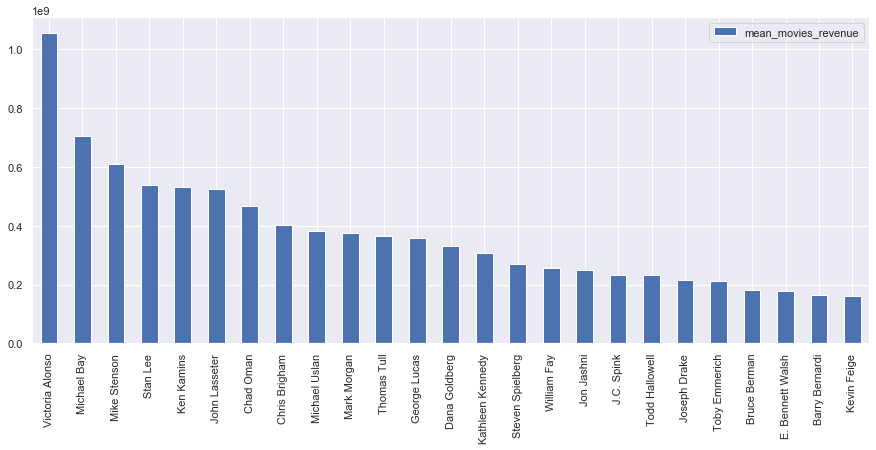

In [47]:
# bivariate executive producers
train.crew = train.crew.fillna("")
train['exec_producers'] = train['crew'].apply(lambda x: re.findall("Executive Producer', 'name': '(.+?)'", x))

exec_producersDict = {}
for element in train[["revenue", "exec_producers"]].values:

    for exec_producer in element[1]:
        if exec_producer not in exec_producersDict:
            exec_producersDict[exec_producer] = [element[0], 1]
        else:
            exec_producersDict[exec_producer][0] += element[0]
            exec_producersDict[exec_producer][1] += 1

exec_producersDict = {k: v for k, v in exec_producersDict.items() if v[1] >= 5}

for exec_producer in exec_producersDict:
    exec_producersDict[exec_producer][0] = exec_producersDict[exec_producer][0]/exec_producersDict[exec_producer][1]
    exec_producersDict[exec_producer] = exec_producersDict[exec_producer][0]




exec_producers_df = pd.DataFrame.from_dict(exec_producersDict, orient='index', columns=["mean_movies_revenue"])
exec_producers_df.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar()

Similarly to the top directors by revenue, the top executive producers by revenue should be a good feature for determining the future success of a film with the same crew. Executive producers are merely another important instance of analyzing the impact of crew members on predicting box office totals. This can be done with any category of crew member.

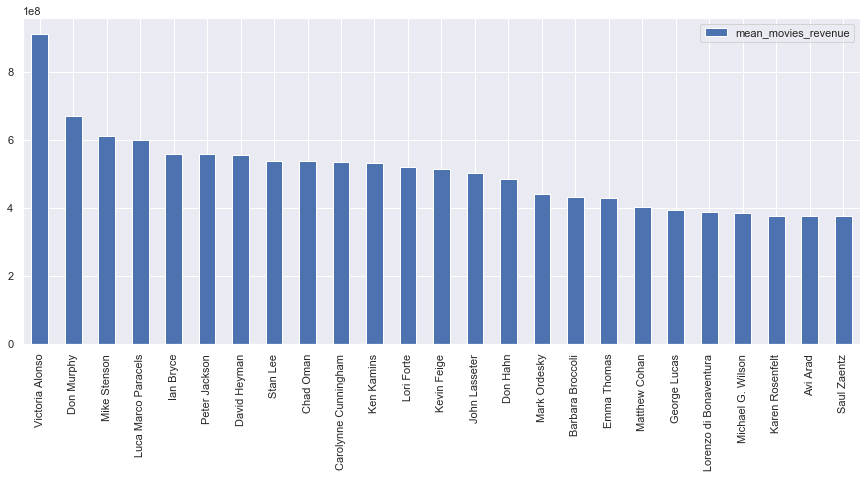

In [48]:
# bivariate producers
train.crew = train.crew.fillna("")
train['producers'] = train['crew'].apply(lambda x: re.findall("Producer', 'name': '(.+?)'", x))

producersDict = {}
for element in train[["revenue", "producers"]].values:

    for producer in element[1]:
        if producer not in producersDict:
            producersDict[producer] = [element[0], 1]
        else:
            producersDict[producer][0] += element[0]
            producersDict[producer][1] += 1

producersDict = {k: v for k, v in producersDict.items() if v[1] >= 5}

for producer in producersDict:
    producersDict[producer][0] = producersDict[producer][0]/producersDict[producer][1]
    producersDict[producer] = producersDict[producer][0]




producers_df = pd.DataFrame.from_dict(producersDict, orient='index', columns=["mean_movies_revenue"])
producers_df.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar()

Changing the search from "Executive Producer" to "Producer" provides different results with some similar/overlapping data.

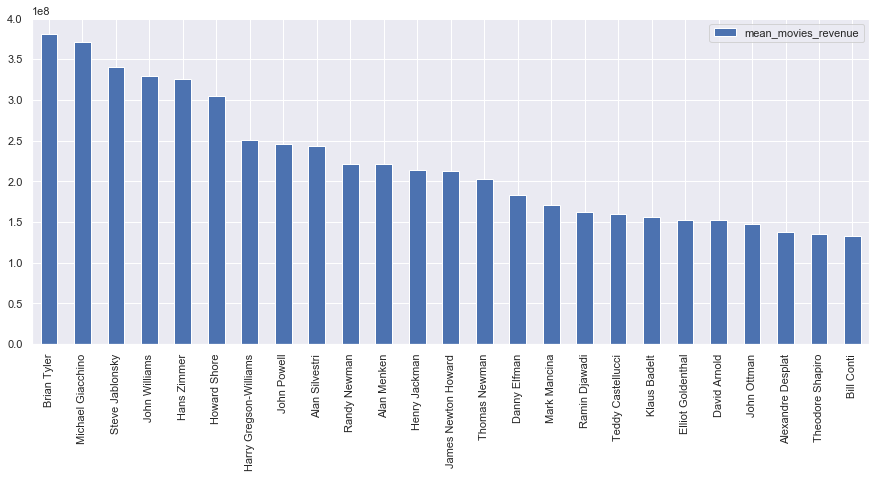

In [49]:
# bivariate composer
train.crew = train.crew.fillna("")
train['composers'] = train['crew'].apply(lambda x: re.findall("Composer', 'name': '(.+?)'", x))

composersDict = {}
for element in train[["revenue", "composers"]].values:

    for composer in element[1]:
        if composer not in composersDict:
            composersDict[composer] = [element[0], 1]
        else:
            composersDict[composer][0] += element[0]
            composersDict[composer][1] += 1

composersDict = {k: v for k, v in composersDict.items() if v[1] >= 5}

for composer in composersDict:
    composersDict[composer][0] = composersDict[composer][0]/composersDict[composer][1]
    composersDict[composer] = composersDict[composer][0]




composers_df = pd.DataFrame.from_dict(composersDict, orient='index', columns=["mean_movies_revenue"])
composers_df.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar()

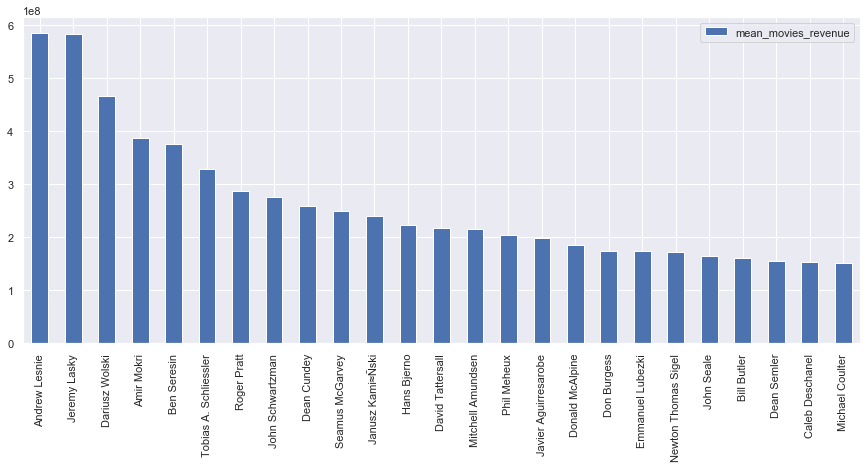

In [50]:
# bivariate director of photography
train.crew = train.crew.fillna("")
train['director_photo'] = train['crew'].apply(lambda x: re.findall("Director of Photography', 'name': '(.+?)'", x))

director_photosDict = {}
for element in train[["revenue", "director_photo"]].values:

    for director_photo in element[1]:
        if director_photo not in director_photosDict:
            director_photosDict[director_photo] = [element[0], 1]
        else:
            director_photosDict[director_photo][0] += element[0]
            director_photosDict[director_photo][1] += 1

director_photosDict = {k: v for k, v in director_photosDict.items() if v[1] >= 5}

for director_photo in director_photosDict:
    director_photosDict[director_photo][0] = director_photosDict[director_photo][0]/director_photosDict[director_photo][1]
    director_photosDict[director_photo] = director_photosDict[director_photo][0]




director_photos_df = pd.DataFrame.from_dict(director_photosDict, orient='index', columns=["mean_movies_revenue"])
director_photos_df.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar()

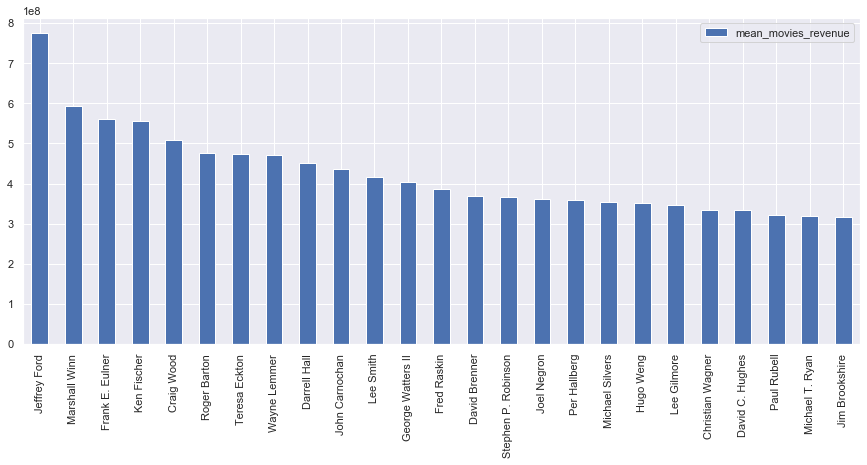

In [51]:
# bivariate editor
train.crew = train.crew.fillna("")
train['editor'] = train['crew'].apply(lambda x: re.findall("Editor', 'name': '(.+?)'", x))

editorsDict = {}
for element in train[["revenue", "editor"]].values:

    for editor in element[1]:
        if editor not in editorsDict:
            editorsDict[editor] = [element[0], 1]
        else:
            editorsDict[editor][0] += element[0]
            editorsDict[editor][1] += 1

editorsDict = {k: v for k, v in editorsDict.items() if v[1] >= 5}

for editor in editorsDict:
    editorsDict[editor][0] = editorsDict[editor][0]/editorsDict[editor][1]
    editorsDict[editor] = editorsDict[editor][0]




editors_df = pd.DataFrame.from_dict(editorsDict, orient='index', columns=["mean_movies_revenue"])
editors_df.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar()